

	
87613259	Scripting Language
=======================================
Credit : Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

## Preparing the dataset
#### Opening the images
Our first step is to recall our previous chapter's lessons and import the things we'll need:

In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping

In [2]:
import os # we need os to do some basic file operations

sentinal_fp = "sentinel-2/"
# find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinal_fp, f) for f in os.listdir(sentinal_fp) if os.path.isfile(os.path.join(sentinal_fp, f))]
sentinal_band_paths.sort()

# create a products directory within the data dir which won't be uploaded to Github
img_dir = 'products/'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands.tif'

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths[0]) as src0:
    meta = src0.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths))

# Read each layer and write it to stack
with rasterio.open(img_fp, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))
            
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(2201, 2629)
8


In [3]:
shapefile = gpd.read_file('training_data//rcr_landcover.shp')
shapefile = shapefile.to_crs({'init': 'epsg:4326'})

# this generates a list of shapely geometries
geoms = shapefile.geometry.values 
# let's grab a single shapely geometry to check
geometry = geoms[0] 
# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
out_image, out_transform = mask(full_dataset, feature, crop=True)
out_image.shape
full_dataset.close()

C:\Users\Attawutn\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Building the Training Data for `scikit-learn`

Now let's do it for all features in the shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.

In [4]:
X = np.array([], dtype=np.int8).reshape(0,8) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# extract the raster values within the polygon 
with rasterio.open(img_fp) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["Classname"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))        

# What are our classification labels?
labels = np.unique(shapefile["Classname"])

def str_class_to_int(class_array):
    class_array[class_array == 'Subtidal Haline'] = 0
    class_array[class_array == 'WetSand'] = 1
    class_array[class_array == 'Emergent Wetland'] = 2
    class_array[class_array == 'Sand'] = 3
    class_array[class_array == 'Herbaceous'] = 4
    class_array[class_array == 'Forested Wetland'] = 5
    return(class_array.astype(int))

## **Split Data**

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

## **Training the Classifier**
Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model.
# Quiz 1 Random Forest
ให้ลองเปลี่ยน Classifier สามารถดูรายละเอียดได้ที่ https://scikit-learn.org/stable/modules/classes.html

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

RandomForestClassifier()

In [25]:
y_pred = clf.predict(X_test)

# Metrics

In [8]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

pscore = metrics.accuracy_score(y_test, y_train)
pscore_train = metrics.accuracy_score(y_train, X_train)

ValueError: Found input variables with inconsistent numbers of samples: [180, 418]

It is that simple to train a classifier in `scikit-learn`! The hard part is often validation and interpretation.

## Predicting on the image

In [12]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib as plt

In [13]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, 150:600, 250:1400]

reshaped_img = reshape_as_image(img)
class_prediction = clf.predict(reshaped_img.reshape(-1, 8))
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)
class_prediction = str_class_to_int(class_prediction)

### Visualize

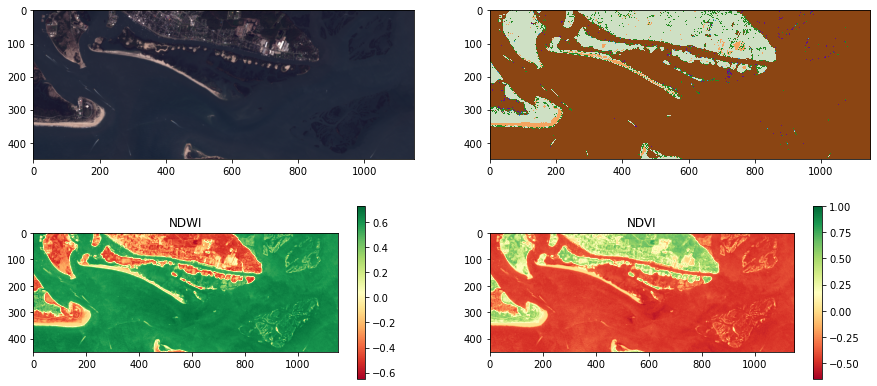

In [26]:
import matplotlib.pyplot as plt

def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

with rasterio.open(img_fp) as src:
    green_band = src.read(3)
    red_band = src.read(4)
    nir_band = src.read(8)
    
ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
ndvi = (nir_band.astype(float) - red_band.astype(float)) / (red_band.astype(float) + nir_band.astype(float))

ndwi = ndwi[150:600, 250:1400]
ndvi = ndvi[150:600, 250:1400]

fig, axs = plt.subplots(2,2,figsize=(15,7))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0,0].imshow(img_stretched)

axs[0,1].imshow(class_prediction, cmap=cmap, interpolation='none')

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlGn")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()

## Neural Network

In [20]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()

clf.fit(X_train,y_train)

MLPClassifier()

In [21]:
y_pred = clf.predict(X_test)

In [22]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

pscore = metrics.accuracy_score(y_test, y_train)
#pscore_train = metrics.accuracy_score(y_train, X_train)

ValueError: Found input variables with inconsistent numbers of samples: [180, 418]

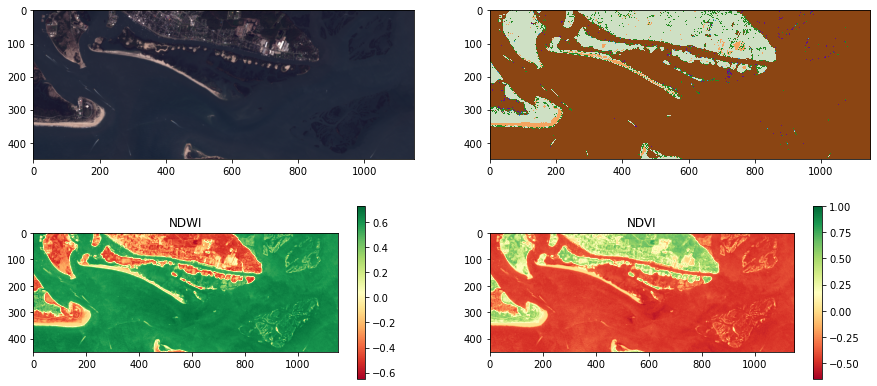

In [23]:
import matplotlib.pyplot as plt

def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

with rasterio.open(img_fp) as src:
    green_band = src.read(3)
    red_band = src.read(4)
    nir_band = src.read(8)
    
ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
ndvi = (nir_band.astype(float) - red_band.astype(float)) / (red_band.astype(float) + nir_band.astype(float))

ndwi = ndwi[150:600, 250:1400]
ndvi = ndvi[150:600, 250:1400]

fig, axs = plt.subplots(2,2,figsize=(15,7))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0,0].imshow(img_stretched)

axs[0,1].imshow(class_prediction, cmap=cmap, interpolation='none')

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlGn")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()